## Data Preprocessing

Diversity: The dataset should represent a diverse population in terms of age, gender, race, and socio-economic background. This will allow the models to consider variations in mental health disorders and treatment responses across different population groups.

Mental Health Diagnoses: The dataset should include patients with various mental health disorders (e.g., depression, anxiety, bipolar disorder, schizophrenia) to capture the complexity and heterogeneity of these conditions.

Demographic Information: The dataset should include demographic features such as age, gender, race, education level, marital status, and socio-economic status.

Mental Health History: The dataset should contain information about patients' mental health history, including previous diagnoses, symptom severity, duration of illness, comorbidities, and family history of mental health disorders.

Treatment History: The dataset should provide comprehensive information on patients' treatment history, including types of treatments (e.g., psychotherapy, medication, electroconvulsive therapy), medications used, dosages, treatment adherence, and treatment outcomes.

--Lifestyle Factors: The dataset should include information on lifestyle factors that may influence mental health and treatment response, such as sleep patterns, physical activity, diet, substance use, and social support.

--Genetic Information: The dataset should include genetic information, such as single nucleotide polymorphisms (SNPs) or other genetic variations associated with mental health disorders or treatment response, if available.

Selected features:

AGE: Age at admission

DSMCRIT: DSM diagnosis (SuDS 4 or SuDS 19) 

Client's diagnosis is used to identify the substance use problem that provides the reason for client encounter or treatment. This can be reported by using either the Diagnostic and Statistical Manual of Mental Disorders (DSM) from the American Psychiatric Association or the International Classification of Diseases (ICD), from the World Health Organization. 

The discrete diagnosis codes have been recoded into categories related to use of and dependence on specific substances, mental health conditions, and other conditions. Diagnoses reported by states using either standard classification of mental disorders have been combined.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

data_dis18 = pd.read_csv('tedsd_puf_2018.csv')
data_dis19 = pd.read_csv('tedsd_puf_2019.csv')
data_dis20 = pd.read_csv('tedsd_puf_2020.csv')

data_dis = pd.concat([data_dis18, data_dis19, data_dis20], axis=0, ignore_index=True)

filtered_dis = data_dis[data_dis['NOPRIOR'] == 0] # Filter No Previous substance use treatment episodes
filtered_dis = filtered_dis[filtered_dis['RACE'] == 6] # Filter Asian
filtered_dis = filtered_dis[filtered_dis['SERVICES'] == 7] # Filter 
filtered_dis = filtered_dis.dropna()  # Drop missing values
data_final = filtered_dis[['MARSTAT','EMPLOY_D','EDUC','PRIMINC','HLTHINS', 
                           'SUB1','LOS','FREQ1','FREQ1_D','PSYPROB','FRSTUSE1','ROUTE1','REASON',
                           'DSMCRIT',]]

X = data_final.drop('DSMCRIT', axis=1)  # Remove target variable from input features
y = data_final['DSMCRIT']  # Target variable

# X = filtered_dis.drop('DSMCRIT', axis=1)  # Remove target variable from input features ALL
# y = filtered_dis['DSMCRIT']  # Target variable

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123) # Train-test split

In [38]:
X_train.shape

(6191, 13)

## RandomForest

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

column_names = data_final.columns
column_names

rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(X, y)

feature_importances = rnd_clf.feature_importances_
importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})
importances_df = importances_df.sort_values('importance', ascending=False)
importances_df

,feature,importance
0,MARSTAT,0.133845
6,LOS,0.118500
5,SUB1,0.101477
3,PRIMINC,0.100657
4,HLTHINS,0.082276
10,FRSTUSE1,0.077790
2,EDUC,0.076414
1,EMPLOY_D,0.059554
12,REASON,0.055229
9,PSYPROB,0.050751


In [41]:
regr = RandomForestRegressor(max_depth=3)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Squared Error: 31.7783
R^2 Score: 0.6570


In [42]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

y_pred_proba = rnd_clf.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Multi-class AUC: {auc}")

Multi-class AUC: 0.9110814133522204


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Train the model
clf = RandomForestClassifier(random_state=123, max_leaf_nodes=16, n_jobs=-1)
params = {'n_estimators': [500],
          'max_depth': [5,10],}
grid_search = GridSearchCV(clf, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_leaf_nodes=16, n_jobs=-1,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'n_estimators': [500]},
             scoring='accuracy')

In [45]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model
y_pred = grid_search.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Accuracy:  0.6273549359457423
Classification Report: 
               precision    recall  f1-score   support

          -9       0.80      0.91      0.85      1251
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        15
           4       0.50      0.01      0.03       219
           5       0.62      0.28      0.39       124
           6       0.00      0.00      0.00        27
           7       0.41      0.19      0.26       137
           8       0.42      0.83      0.56       150
           9       0.40      0.45      0.42       247
          10       0.41      0.50      0.45       154
          11       0.00      0.00      0.00        39
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         1
          16       0.00   

C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

mlp = MLPClassifier(
    hidden_layer_sizes=(100, ), 
    activation='relu', 
    solver='adam', 
    max_iter=300, 
    random_state=42)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

y_pred_proba = mlp.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Multi-class AUC: {auc}")

[[1115    0    0    2   23   17    2   14   10   28   26    1    0    1
     0    0    0    0   12]
 [   6    0    0    0    3    2    0    2    0    6    0    0    0    0
     0    0    0    0    1]
 [   5    0    6    0    1    2    1    3    8    0    4    0    0    0
     0    0    0    0    2]
 [   0    0    0    4    2    1    0    0    2    5    0    0    0    0
     0    0    0    0    1]
 [  23    0    2    2   49    6    3    4   10   63    1    1    0    0
     0    0    0    0   55]
 [  20    0    0    0    1   57    1    8   21    3    4    2    1    0
     0    0    0    0    6]
 [   5    0    1    0    3    4    7    0    1    1    0    0    0    1
     0    0    0    0    4]
 [  17    0    0    0    2    5    0   59    5    4   28    0    0    0
     0    0    0    0   17]
 [   4    0    0    0    4   11    0    0  109    3    5   10    0    0
     0    0    0    0    4]
 [  25    0    1    5   43    5    2    3    7   92    5    0    0    0
     0    0    0    0   59]


C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are 

## ANN

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

def ANN(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [34]:
input_dim = 13
num_classes = 1

ANN_model = ANN(input_dim, num_classes)
optimizer = Adam(learning_rate=0.001)
ANN_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

ANN_model.summary()
history = ANN_model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split=0.3)
test_loss, test_acc = ANN_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 256)               3584      
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dense_27 (Dense)            (None, 64)                8256      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 44,801
Trainable params: 44,801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
87/87 [==============================] - 1s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 2/100
87/87 [==============

87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 50/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 51/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 52/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 53/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 54/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_loss: 0.0000e+00 - val_accuracy: 0.0097
Epoch 55/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.0060 - val_los

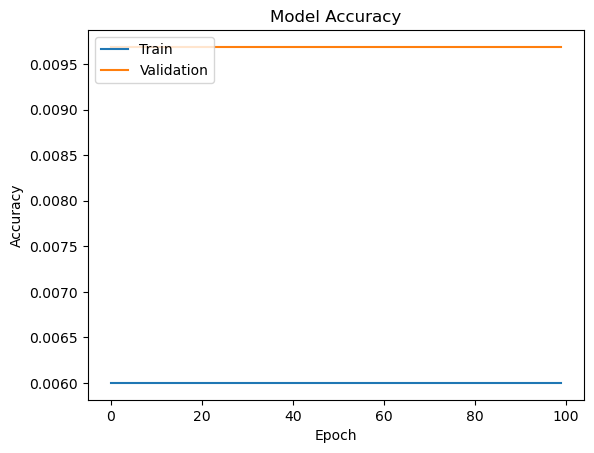

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

classifier = LogisticRegression(multi_class='ovr')
classifier.fit(X_train, y_train)

y_pred_proba = classifier.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Multi-class AUC: {auc}")

y_pred = classifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report: \n", classification_report(y_test, y_pred))

Multi-class AUC: 0.8618731654026116
Accuracy:  0.573474001507159
Classification Report: 
               precision    recall  f1-score   support

          -9       0.76      0.86      0.81      1251
           1       0.00      0.00      0.00        20
           2       0.50      0.03      0.06        32
           3       0.00      0.00      0.00        15
           4       0.32      0.16      0.22       219
           5       0.20      0.04      0.07       124
           6       0.00      0.00      0.00        27
           7       0.38      0.06      0.10       137
           8       0.38      0.59      0.46       150
           9       0.36      0.39      0.38       247
          10       0.34      0.32      0.33       154
          11       0.00      0.00      0.00        39
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00  

C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SL

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

base_models = [
    ('random_forest', RandomForestClassifier(random_state=123)),
    ('svm', SVC(probability=True)),
    ('logistic_regression', LogisticRegression())
]

meta_model = LogisticRegression()

stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_model)
stacking_classifier.fit(X_train, y_train)
y_pred = stacking_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Super Learner Accuracy: {accuracy}")

y_pred_proba = stacking_classifier.predict_proba(X_test)
auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Multi-class AUC: {auc}")

C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\qiany9\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:1092: RuntimeWarning: Number of classes in training fold (18) does not match total number of classes (19). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resu

Super Learner Accuracy: 0.6782215523737755
Multi-class AUC: 0.9041912753914999
